In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [101]:
root_dir='FashionMnist'

train_data=datasets.FashionMNIST(
            root=root_dir,
            train=True,
            transform=transforms.ToTensor(),
            download=True)

test_data=datasets.FashionMNIST(
            root=root_dir,
            train=False,
            transform=transforms.ToTensor(),
            download=True)

In [102]:
test_data.test_labels[1].item()

C:\Users\uchag\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


2

In [103]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

In [18]:
def img_view(data,index,label):
    plt.imshow(data.train_data[index],cmap='gray')
    plt.title(f'data label:{label[data.targets[index].item()]} ')
    

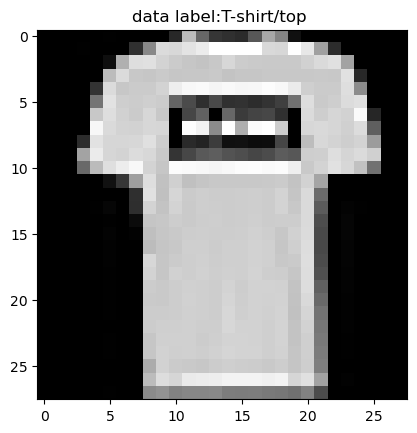

In [19]:
img_view(train_data,1,label_map)

In [104]:
batch=64

train_data_loader=DataLoader(dataset=train_data,
                            batch_size=batch,
                            shuffle=True)
test_data_loader=DataLoader(dataset=test_data,
                            batch_size=batch,
                            shuffle=True)

In [105]:
for x,y in train_data_loader:
    print(x.shape)
    break

torch.Size([64, 1, 28, 28])


In [106]:
device='cuda' if torch.cuda.is_available else "cpu"

In [107]:
class CNN(nn.Module):
    def __init__(self,in_,out_):
        super().__init__()
        
        self.conv_pool_01=nn.Sequential(
        nn.Conv2d(in_channels=in_,stride=1,padding=0,kernel_size=5,out_channels=8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_pool_02=nn.Sequential(
        nn.Conv2d(in_channels=8,stride=1,padding=0,out_channels=16,kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.flatten=nn.Flatten()
        self.FC_01=nn.Linear(in_features=16*4*4,out_features=128)
        self.FC_02=nn.Linear(in_features=128,out_features=64)
        self.FC_03=nn.Linear(in_features=64,out_features=out_)
        
    def forward(self,x):
        x=self.conv_pool_01(x)
        x=self.conv_pool_02(x)
        x=self.flatten(x)
        x=self.FC_01(x)
        x=self.FC_02(x)
        x=self.FC_03(x)
        return x
        
        

In [108]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
        
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)        
        x = self.FC_03(x)
        return x

In [109]:
model=CNN(1,10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [110]:
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = 0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param = parameters.numel()
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total trainable parameters: {total}")
    return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


model.parameters

In [111]:
next(model.parameters()).is_cuda

True

In [112]:
lr=0.001
epochs=10
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [113]:
steps=len(train_data_loader)

In [100]:
for epoch in range(epochs):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images,labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{epochs}")
            
            images = images.to(device)
            labels = labels.to(device)   
            
            outputs=model(images)
            loss=criterion(outputs,labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            
            tqdm_epoch.set_postfix(loss=loss.item())
            
        

Epoch 10/10: 100%|█████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.25it/s, loss=0.187]


In [125]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        image, label = data[0].to(device), data[1].to(device)
        
        y_pred = model(image)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

In [131]:
pred

array([8., 8., 8., ..., 8., 8., 8.])

In [132]:
data=next(iter(test_data_loader))



Text(0.5, 1.0, 'Bag')

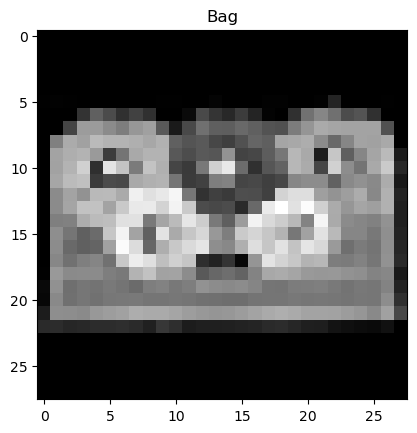

In [137]:
image,label = data

img=image[0]
img.shape
plt.imshow(img.permute(1,2,0),cmap='gray')
plt.title(label_map[label[0].item()])

In [152]:
def predict(data,model,label,device,idx):
    image,label=data
    img=image[idx]
    label=label[idx]
    
    plt.imshow(img.permute(1,2,0), cmap="gray")

    img=img.unsqueeze(1).to(device)
    logits=model(img)
    pred_prob=F.softmax(logits,1)
    argmax=torch.argmax(pred_prob,1).item()
    predicted_label=label_map[argmax]
    actual_label = label_map[label.item()]
    plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
    return predicted_label, actual_label


('Bag', 'Coat')

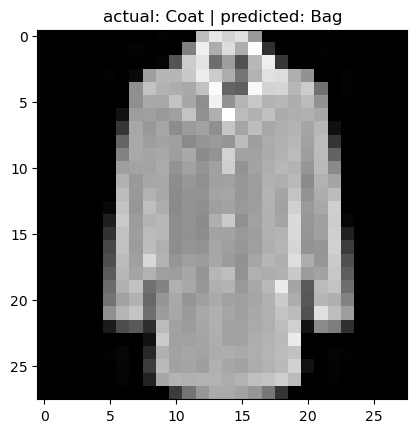

In [153]:
data = next(iter(test_data_loader))
predict(data, model, label_map, device, idx=0)
